# Capstone Project - The Battle of Neighborhoods

### Exploratory Data Analysis

Importing all libraries 

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Importing data to pandas dataframe

In [4]:
city_in_india = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population')[0]
city_in_india.head()

,Rank,City,Population(2011)[3],Population(2001),State or union territory
0,1,Mumbai,12442373,11978450,Maharashtra
1,2,Delhi,11007835,9879172,Delhi
2,3,Bangalore,8436675,4301326,Karnataka
3,4,Hyderabad,6809970,3637483,Telangana
4,5,Ahmedabad,5570585,3520085,Gujarat


droping population and ranking column

In [5]:
city_in_india = city_in_india.drop(["Rank", "Population(2011)[3]", "Population(2001)"], axis=1)
city_in_india.head()

,City,State or union territory
0,Mumbai,Maharashtra
1,Delhi,Delhi
2,Bangalore,Karnataka
3,Hyderabad,Telangana
4,Ahmedabad,Gujarat


Limiting dataframe to first 100 row to get only major cities

In [6]:
city_in_india = city_in_india[:100]

In [7]:
city_in_india.shape

(100, 2)

In [8]:
city_in_india.head()

,City,State or union territory
0,Mumbai,Maharashtra
1,Delhi,Delhi
2,Bangalore,Karnataka
3,Hyderabad,Telangana
4,Ahmedabad,Gujarat


Getting location data using geocoder, denoting location value as 0 for cities where data is not available

In [9]:
for i in range(len(city_in_india)):
    try:
        city_in_india.loc[i, 'latitude'] = Nominatim(user_agent="ny_explorer").geocode(city_in_india.loc[i, 'City']).latitude
    except:
        city_in_india.loc[i, 'latitude'] = 0
    
    try:
        city_in_india.loc[i, 'longitude'] = Nominatim(user_agent="ny_explorer").geocode(city_in_india.loc[i, 'City']).longitude
    except:
        city_in_india.loc[i, 'longitude'] = 0



In [9]:
city_in_india.shape

(100, 4)

Remving rows where location data is unavailable

In [10]:
city_in_india = city_in_india[city_in_india['latitude'] != 0]
city_in_india = city_in_india[city_in_india['longitude'] != 0]

In [11]:
city_in_india.shape

(90, 4)

In [12]:
city_in_india.head()

,City,State or union territory,latitude,longitude
0,Mumbai,Maharashtra,19.075990,72.877393
1,Delhi,Delhi,28.651718,77.221939
2,Bangalore,Karnataka,12.979120,77.591300
3,Hyderabad,Telangana,17.360589,78.474061
4,Ahmedabad,Gujarat,23.021624,72.579707


Retrieving location of India to plot graph

In [11]:
address = 'India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of India are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of India are 22.3511148, 78.6677428.


create map of India using latitude and longitude values from city datafra

In [14]:
map_india = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, borough, neighborhood in zip(city_in_india['latitude'], city_in_india['longitude'], city_in_india['State or union territory'], city_in_india['City']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_india)  
    
map_india

#### Let's create a function to find nearby venue in all the City in India

In [12]:
CLIENT_ID = 'GQBGV2LF12JEMLGIP4SVNNRPIRT0PYKFTUIVCF50Y5KRCV1E' # your Foursquare ID
CLIENT_SECRET = 'VUEHEJVEUKKYBCXHXI5ONCEJCQSIQB2ESOUCZBLPTPIOISCR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Lets retrieve all the cities with top venues

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
india_venue = getNearbyVenues(names=city_in_india['City'],
                                   latitudes=city_in_india['latitude'],
                                   longitudes=city_in_india['longitude']
                                  )


Mumbai
Delhi
Bangalore
Hyderabad
Ahmedabad
Chennai
Kolkata
Surat
Pune
Jaipur
Lucknow
Kanpur
Nagpur
Indore
Thane
Bhopal
Pimpri-Chinchwad
Patna
Vadodara
Ghaziabad
Ludhiana
Agra
Nashik
Ranchi
Faridabad
Meerut
Rajkot
Kalyan-Dombivli
Vasai-Virar
Varanasi
Srinagar
Aurangabad
Dhanbad
Amritsar
Navi Mumbai
Allahabad
Howrah
Gwalior
Jabalpur
Coimbatore
Vijayawada
Jodhpur
Madurai
Raipur
Chandigarh
Guwahati
Solapur
Hubli–Dharwad
Bareilly
Aligarh
Tiruppur
Gurgaon
Moradabad
Jalandhar
Bhubaneswar
Salem
Mira-Bhayandar
Jalgaon
Thiruvananthapuram
Bhiwandi
Saharanpur
Gorakhpur
Bikaner
Amravati
Noida
Jamshedpur
Bhilai
Cuttack
Firozabad
Kochi
Bhavnagar
Dehradun
Durgapur
Asansol
Rourkela
Nanded
Kolhapur
Ajmer
Akola
Gulbarga
Jamnagar
Ujjain
Loni
Siliguri
Jhansi
Ulhasnagar
Sangli-Miraj & Kupwad
Mangalore
Belgaum
Ambattur


In [18]:
india_venue.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mumbai,19.07599,72.877393,Hitchki,19.069730,72.869761,Bar
1,Mumbai,19.07599,72.877393,Sofitel Mumbai BKC,19.067448,72.869006,Hotel
2,Mumbai,19.07599,72.877393,Hamleys,19.086655,72.889783,Toy / Game Store
3,Mumbai,19.07599,72.877393,Trident,19.066808,72.867468,Hotel
4,Mumbai,19.07599,72.877393,PVR Cinemas,19.086643,72.889839,Movie Theater


In [19]:
india_venue.shape

(3477, 7)

Convert dataframe to dummy data set based on column Venue Category

In [15]:
india_onehot = pd.get_dummies(india_venue[['Venue Category']], prefix="", prefix_sep="")
india_onehot['City'] = india_venue['City'] 
fixed_columns = [india_onehot.columns[-1]] + list(india_onehot.columns[:-1])
india_onehot = india_onehot[fixed_columns]
india_onehot.head()

,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Canal,Cave,Chaat Place,Chinese Restaurant,Chocolate Shop,City,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,Gift Shop,Goan Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hindu Temple,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Outdoors & Recreation,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Sikh Temple,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Water Park,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
india_onehot.shape
india_grouped = india_onehot.groupby('City').mean().reset_index()
india_grouped.shape


(87, 248)

Retrieve top 10 venues for each city

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = india_grouped['City']

for ind in np.arange(india_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(india_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agra,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Historic Site,Multicuisine Indian Restaurant,Pizza Place,Resort,Market,Bus Station
1,Ahmedabad,Indian Restaurant,Café,Hotel,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Coffee Shop,Sandwich Place,Pizza Place,History Museum
2,Ajmer,Movie Theater,Bus Station,Lake,Hotel,Vegetarian / Vegan Restaurant,Pizza Place,Indian Restaurant,Multiplex,Museum,North Indian Restaurant
3,Akola,Train Station,Zoo,Optical Shop,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,National Park
4,Aligarh,ATM,Motorcycle Shop,Burger Joint,IT Services,Music Venue,Nightclub,New American Restaurant,Neighborhood,Nature Preserve,National Park


Performing cluster analysis to get different clusters

In [39]:
# set number of clusters
kclusters = 20

india_grouped_clustering = india_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(india_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]


array([14,  0,  0,  1,  9,  8,  8,  8,  4, 14,  0, 11,  0,  8, 17,  7,  6,
        6, 10,  6], dtype=int32)

In [45]:
# add clustering labels
city_venues_sorted = city_venues_sorted.drop(['Cluster Labels'], axis = 1)

city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

india_merged = city_in_india

# merge india_grouped with india_data to add latitude/longitude for each city
india_merged = india_merged.join(city_venues_sorted.set_index('City'), on='City')

india_merged.head() # check the last columns!


,City,State or union territory,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mumbai,Maharashtra,19.075990,72.877393,0.0,Indian Restaurant,Hotel,Coffee Shop,Bar,Lounge,Dessert Shop,Restaurant,Ice Cream Shop,Italian Restaurant,Asian Restaurant
1,Delhi,Delhi,28.651718,77.221939,0.0,Indian Restaurant,Hotel,Café,Bar,Lounge,Dessert Shop,Fast Food Restaurant,Snack Place,Coffee Shop,South Indian Restaurant
2,Bangalore,Karnataka,12.979120,77.591300,0.0,Indian Restaurant,Hotel,Ice Cream Shop,Pub,Brewery,Steakhouse,Lounge,Shopping Mall,Breakfast Spot,Japanese Restaurant
3,Hyderabad,Telangana,17.360589,78.474061,0.0,Indian Restaurant,Café,Coffee Shop,South Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Diner,History Museum,Restaurant,Pizza Place
4,Ahmedabad,Gujarat,23.021624,72.579707,0.0,Indian Restaurant,Café,Hotel,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Coffee Shop,Sandwich Place,Pizza Place,History Museum


In [46]:
india_merged = india_merged.dropna()
india_merged.shape


(87, 15)

In [47]:
india_merged['Cluster Labels'] = india_merged['Cluster Labels'].astype(int)
print(india_merged['Cluster Labels'].unique())


[ 0  6  3 14  8 15 19  2 11  9 18  7 10 17  5  4 16  1 12 13]


PLoting different clusters on map

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(india_merged['latitude'], india_merged['longitude'], india_merged['City'], india_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Correlation Analysis

#### First retrieve india_group for correlation analysis
To compare cities with each other, we need a dataset which contains venue category for every city and that's why india_grouped is best choice for it, but before we can use it for our purpose we need to transform it.

In [17]:
india_grouped.head()

,City,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Canal,Cave,Chaat Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,Gift Shop,Goan Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hindu Temple,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Outdoors & Recreation,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Sikh Temple,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Water Park,Wine Bar,Wings Joint,Women's Store
0,Agra,0.000000,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.017544,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035088,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.052632,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.

#### Retrieving most common venues

In [70]:
sum_venue_categort = india_grouped[india_grouped.columns[1:]].sum(axis = 0)
sum_venue_categort.sort_values(ascending=False)


Indian Restaurant                           8.203733
Hotel                                       5.632986
Café                                        5.630529
Pizza Place                                 5.352209
Train Station                               4.663150
Fast Food Restaurant                        4.270497
Shopping Mall                               3.941132
Multiplex                                   3.267795
Restaurant                                  2.576644
Coffee Shop                                 2.470057
Bakery                                      1.914108
Ice Cream Shop                              1.913890
ATM                                         1.498889
Platform                                    1.390738
Asian Restaurant                            1.294950
Mobile Phone Shop                           1.152857
Clothing Store                              1.129793
Chinese Restaurant                          1.123780
Movie Theater                               1.

#### Make a copy of this dataframe for our analysis so it doesn't affect cluster analysis

In [41]:
corr_city = india_grouped.copy()

In [42]:
corr_city.set_index('City')

,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Canal,Cave,Chaat Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,Gift Shop,Goan Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hindu Temple,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Outdoors & Recreation,Park,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Sikh Temple,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Water Park,Wine Bar,Wings Joint,Women's Store
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agra,0.000000,0.000000,0.00,0.00,0.000000,0.017544,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,

#### Transposing dataframe to get each column as a city for correlation analysis 

In [43]:
final_corr_city = corr_city.T

In [44]:
final_corr_city.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
Zoo,0,0.0105263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0106383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATM,0,0,0,0,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0,0.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Accessories Store,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Afghan Restaurant,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Replacing column name to city name

In [45]:
final_corr_city.columns = final_corr_city.iloc[0]
final_corr_city.head()

City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
Zoo,0,0.0105263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0106383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATM,0,0,0,0,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0,0.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Accessories Store,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Afghan Restaurant,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Removing 'City' row

In [46]:
final_corr_city = final_corr_city.drop(['City'])
final_corr_city.head()

City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
Zoo,0,0.0105263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0106383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATM,0,0,0,0,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0,0.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Accessories Store,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Afghan Restaurant,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
African Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0113636,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### To retrieve correlation matrix firstly we need to check datatype of each column

In [47]:
print(final_corr_city.dtypes)

City
Agra                     object
Ahmedabad                object
Ajmer                    object
Akola                    object
Aligarh                  object
Allahabad                object
Ambattur                 object
Amritsar                 object
Asansol                  object
Aurangabad               object
Bangalore                object
Bareilly                 object
Belgaum                  object
Bhavnagar                object
Bhilai                   object
Bhiwandi                 object
Bhopal                   object
Bhubaneswar              object
Bikaner                  object
Chandigarh               object
Chennai                  object
Coimbatore               object
Cuttack                  object
Dehradun                 object
Delhi                    object
Dhanbad                  object
Durgapur                 object
Faridabad                object
Firozabad                object
Ghaziabad                object
Gulbarga                 object
Gur

#### Changing datatypes to float

In [48]:
final_corr_city = final_corr_city.astype(float)

In [49]:
print(final_corr_city.dtypes)

City
Agra                     float64
Ahmedabad                float64
Ajmer                    float64
Akola                    float64
Aligarh                  float64
Allahabad                float64
Ambattur                 float64
Amritsar                 float64
Asansol                  float64
Aurangabad               float64
Bangalore                float64
Bareilly                 float64
Belgaum                  float64
Bhavnagar                float64
Bhilai                   float64
Bhiwandi                 float64
Bhopal                   float64
Bhubaneswar              float64
Bikaner                  float64
Chandigarh               float64
Chennai                  float64
Coimbatore               float64
Cuttack                  float64
Dehradun                 float64
Delhi                    float64
Dhanbad                  float64
Durgapur                 float64
Faridabad                float64
Firozabad                float64
Ghaziabad                float64
Gulba

#### Retrieving correlation matrix

In [50]:
final_corr_city.corr()

City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agra,1.000000,0.707224,0.536000,-0.013823,-0.026260,0.337391,0.331171,0.609927,0.019258,0.688884,0.654188,-0.013823,0.497055,0.137019,0.114028,0.394418,0.621501,0.551095,0.782412,0.435120,0.649969,0.561512,0.046276,0.318526,0.691343,0.237559,0.042794,0.536940,0.010684,0.419184,-0.019588,0.560972,0.251316,0.218160,0.568768,0.755288,0.527154,0.589871,0.159908,0.871426,0.561679,0.518430,0.584391,-0.013823,0.903770,0.298382,0.259060,0.757779,0.649266,0.403224,0.032452,0.714553,0.473129,0.707796,0.432919,0.290414,0.483401,0.236473,0.601420,0.466110,0.002318,0.614567,0.551654,0.573696,0.539533,0.653870,0.609820,0.248397,0.567887,0.473512,0.658013,0.211911,0.080181,0.384937,0.303566,-0.013823,0.462693,0.046076,0.474622,0.454253,0.633070,0.064616,0.351352,0.560256,0.832158,0.358539,0.685367
Ahmedabad,0.707224,1.000000,0.436395,0.072793,-0.032926,0.431695,0.620302,0.738768,0.069804,0.680732,0.610154,-0.017332,0.741187,0.359117,0.421771,0.459469,0.616941,0.562939,0.434451,0.606363,0.804995,0.761701,0.047247,0.657553,0.788559,0.366011,0.149111,0.635853,0.022104,0.559753,0.039297,0.648259,0.496725,0.451338,0.594287,0.697320,0.788584,0.795181,0.403933,0.699215,0.600218,0.481905,0.595544,0.072793,0.754138,0.601053,0.511211,0.767705,0.771378,0.392977,0.010463,0.854740,0.759231,0.701169,0.650870,0.283900,0.694808,0.090009,0.623234,0.692910,-0.034877,0.804209,0.804853,0.744090,0.662417,0.827564,0.748946,0.571734,0.639073,0.614609,0.393507,0.286021,0.240925,0.638458,0.403933,-0.017332,0.585256,0.027731,0.746053,0.578797,0.689602,0.105800,0.524760,0.809870,0.672400,0.462442,0.791667
Ajmer,0.536000,0.436395,1.000000,-0.010889,-0.020686,0.261886,0.420562,0.481071,0.125299,0.401583,0.388668,-0.010889,0.280103,0.095002,0.131527,0.279221,0.349156,0.350854,0.411934,0.204080,0.441158,0.421739,-0.031246,0.201503,0.382588,0.290001,0.069955,0.466382,-0.018937,0.360865,-0.015430,0.329956,0.301202,0.106570,0.283451,0.495363,0.338252,0.367199,0.074613,0.479486,0.436226,0.265433,0.361607,-0.010889,0.494812,0.196152,0.129308,0.442846,0.475861,0.191305,0.171379,0.378007,0.329878,0.571131,0.302818,0.113553,0.420222,0.087436,0.350541,0.355253,-0.021911,0.445533,0.369086,0.448012,0.380805,0.451013,0.423108,0.153491,0.477800,0.351561,0.407408,0.321933,0.122333,0.295667,0.237226,-0.010889,0.289904,-0.010889,0.282424,0.440723,0.466551,0.131527,0.403381,0.357870,0.565833,0.471411,0.437096
Akola,-0.013823,0.072793,-0.010889,1.000000,-0.007723,0.180471,-0.015778,-0.016284,0.373777,-0.014568,-0.021455,-0.004065,0.124332,-0.010399,0.404078,-0.007381,0.111674,-0.018741,0.218222,-0.020565,0.084200,0.026064,0.348487,0.111482,-0.018261,0.404078,0.236465,-0.014878,-0.007070,0.243466,0.705668,-0.015307,0.073907,-0.011665,0.203106,0.140777,0.093342,-0.018049,-0.012617,-0.013292,-0.013765,0.183590,0.159716,1.000000,0.031785,0.062339,0.095528,-0.017247,-0.016507,-0.022082,-0.008180,-0.013851,-0.014150,0.050672,0.050512,-0.008685,0.093551,-0.011176,-0.019351,-0.019504,-0.008180,-0.012139,-0.018449,-0.018115,0.142165,0.027147,-0.020195,-0.011740,0.097355,-0.011312,0.272121,-0.009165,-0.020991,-0.010257,0.412337,-0.004065,

In [51]:
final_corr_city.describe()

City,Agra,Ahmedabad,Ajmer,Akola,Aligarh,Allahabad,Ambattur,Amritsar,Asansol,Aurangabad,Bangalore,Bareilly,Belgaum,Bhavnagar,Bhilai,Bhiwandi,Bhopal,Bhubaneswar,Bikaner,Chandigarh,Chennai,Coimbatore,Cuttack,Dehradun,Delhi,Dhanbad,Durgapur,Faridabad,Firozabad,Ghaziabad,Gulbarga,Gurgaon,Guwahati,Gwalior,Howrah,Hubli–Dharwad,Hyderabad,Indore,Jabalpur,Jaipur,Jalandhar,Jamnagar,Jamshedpur,Jhansi,Jodhpur,Kalyan-Dombivli,Kanpur,Kochi,Kolhapur,Kolkata,Loni,Lucknow,Ludhiana,Madurai,Mangalore,Meerut,Mira-Bhayandar,Moradabad,Mumbai,Nagpur,Nanded,Nashik,Navi Mumbai,Noida,Patna,Pimpri-Chinchwad,Pune,Raipur,Rajkot,Ranchi,Rourkela,Saharanpur,Salem,Sangli-Miraj & Kupwad,Siliguri,Solapur,Srinagar,Surat,Thane,Thiruvananthapuram,Tiruppur,Ujjain,Ulhasnagar,Vadodara,Varanasi,Vasai-Virar,Vijayawada
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,0.004049,0.004049,0.003543,0.004049,0.004049,0.004049,0.004049,0.003959,0.004049,0.003893,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.003599,0.003961,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.003959,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.003873,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.003996,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.003856,0.004049,0.004049,0.003997,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049,0.004049
std,0.018712,0.014924,0.020785,0.063628,0.033493,0.020692,0.016393,0.015531,0.033493,0.017072,0.012055,0.063628,0.018473,0.024874,0.025711,0.035042,0.013575,0.013802,0.031476,0.012304,0.014173,0.014588,0.022174,0.016782,0.014164,0.025711,0.028926,0.017385,0.036586,0.025178,0.044901,0.016898,0.015788,0.022174,0.010825,0.018791,0.011792,0.014331,0.020501,0.019459,0.017974,0.019061,0.019433,0.063628,0.020172,0.018625,0.017558,0.014997,0.015669,0.011713,0.031620,0.018673,0.018280,0.020626,0.011372,0.029781,0.014973,0.023143,0.013367,0.013262,0.031620,0.021308,0.014020,0.014278,0.017719,0.016334,0.012807,0.022032,0.016093,0.022864,0.032589,0.028223,0.012322,0.025218,0.020501,0.063628,0.017802,0.063628,0.011397,0.011789,0.020972,0.025711,0.025218,0.015693,0.021407,0.016681,0.016393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

####  Ploting correlation heatmap using seaborn library

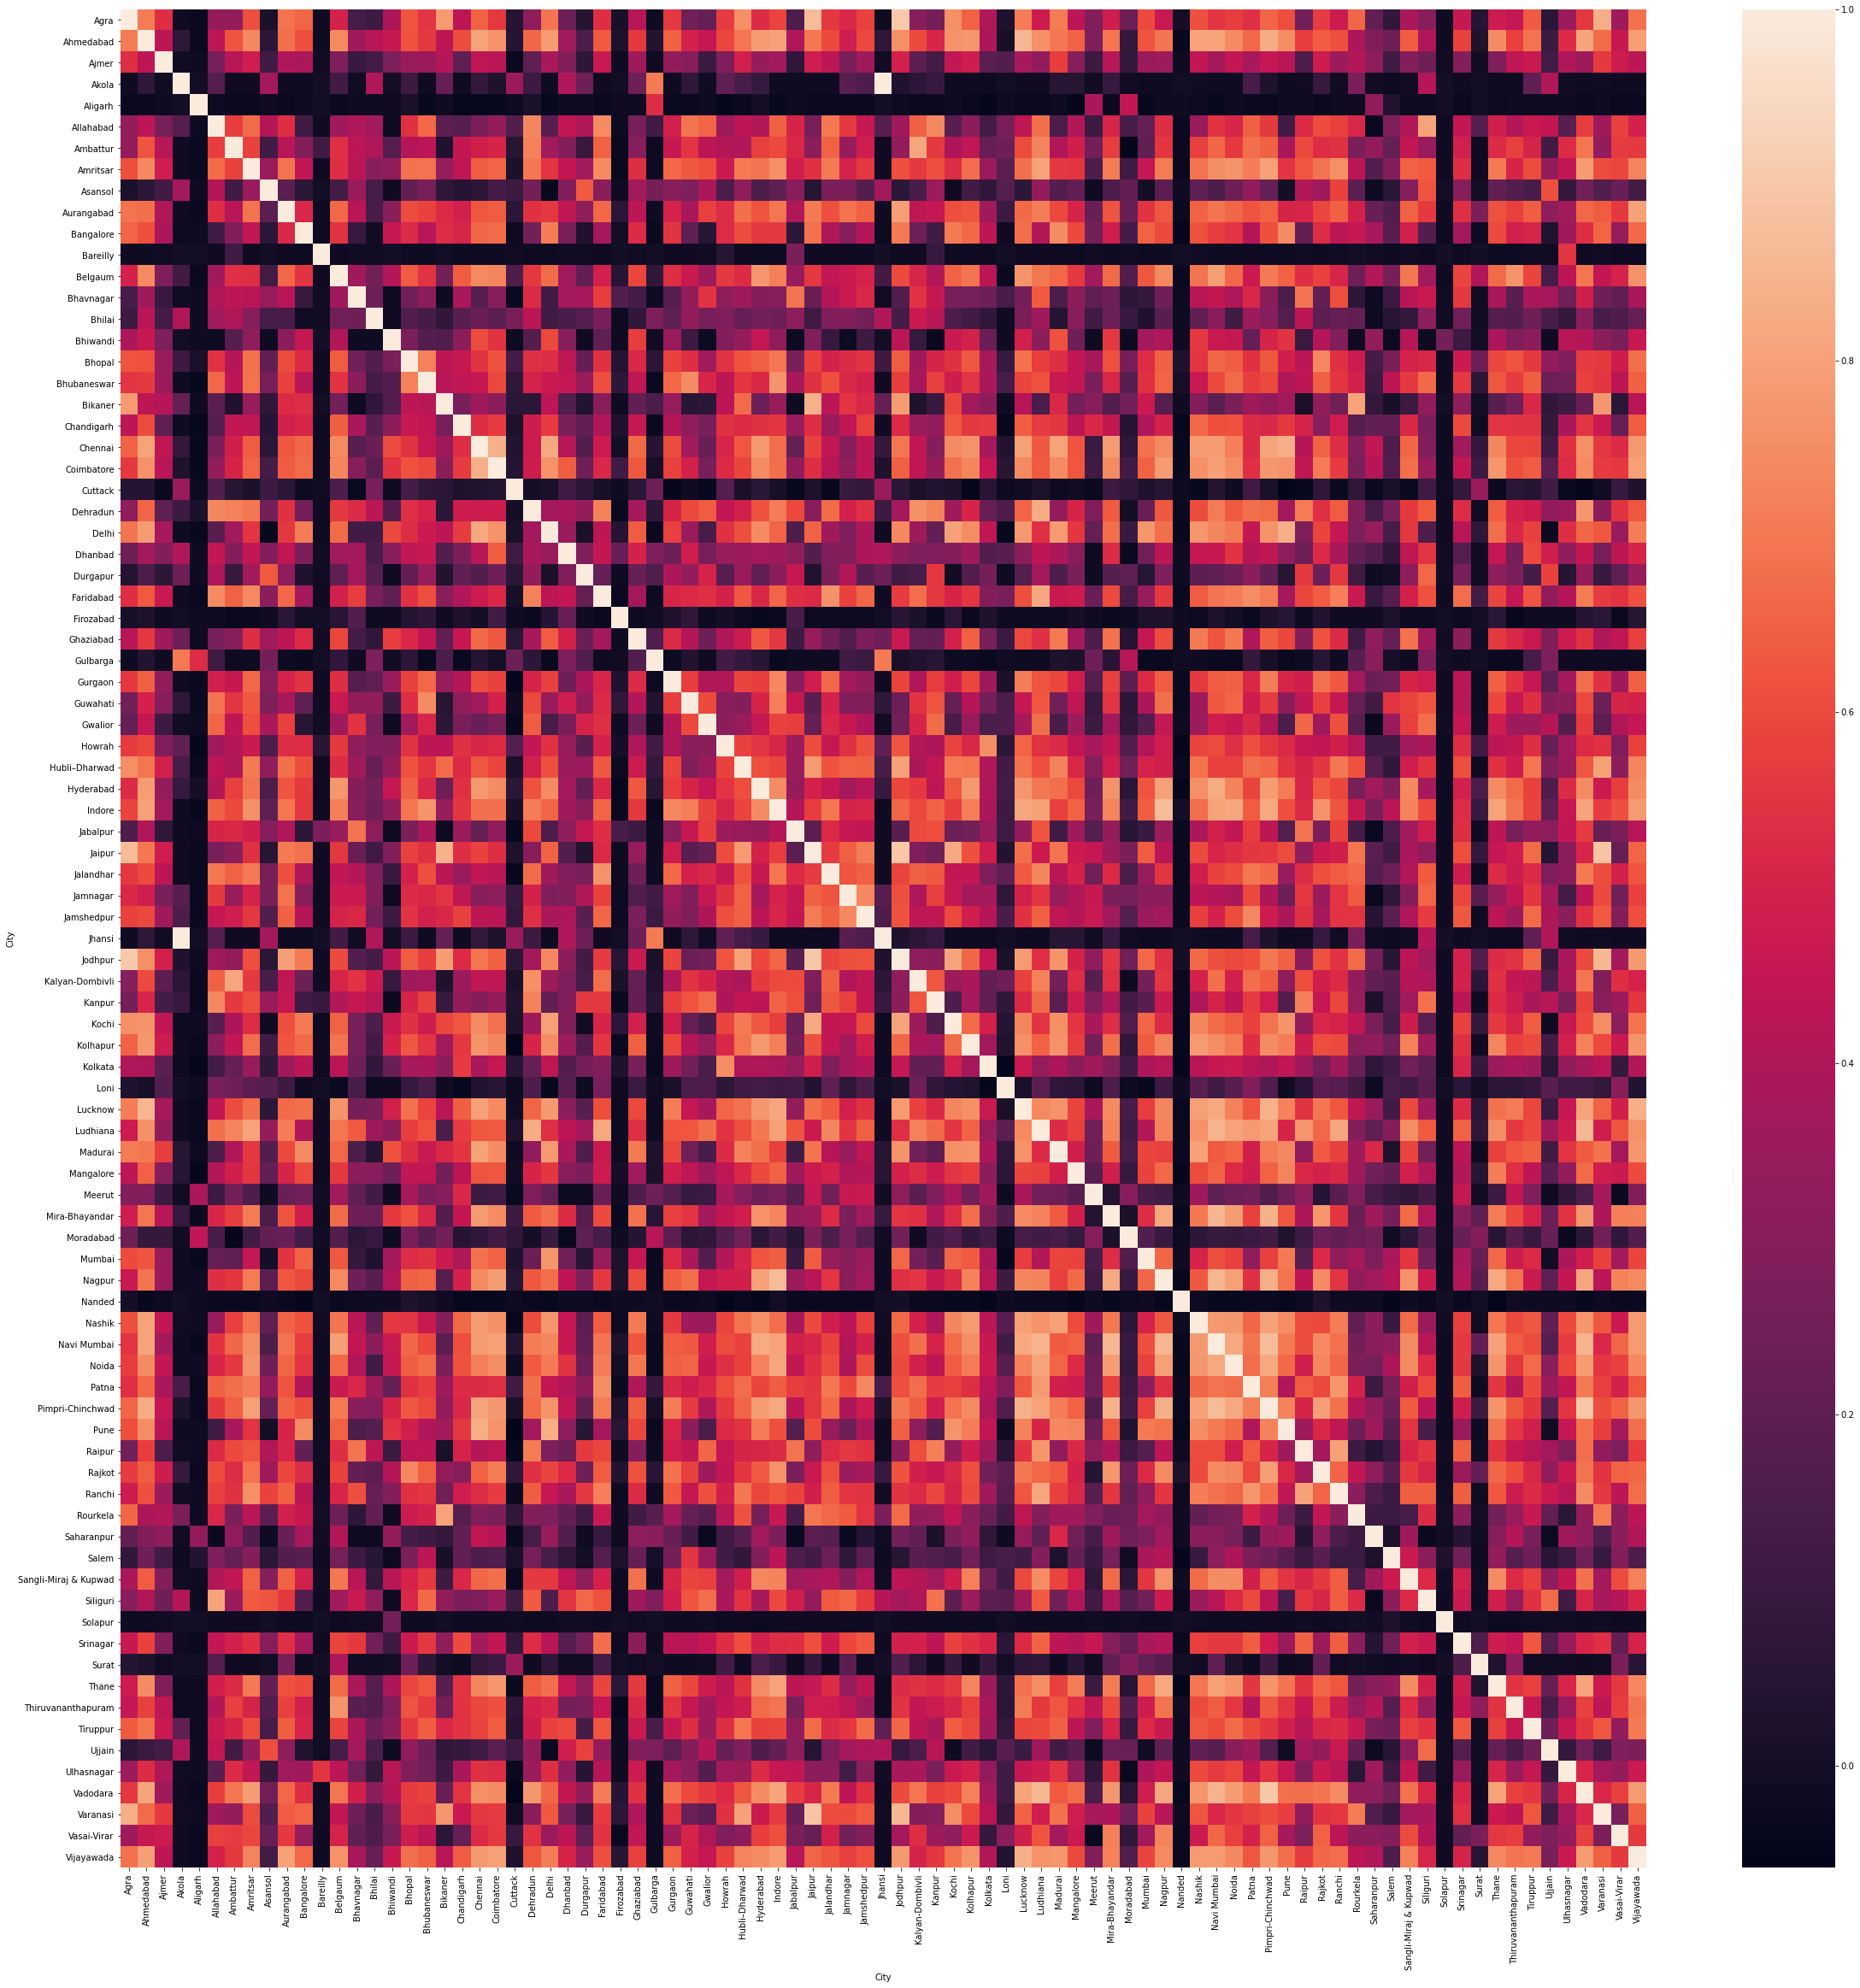

In [52]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(40,40)) 
# play with the figsize until the plot is big enough to plot all the columns
# of your dataset, or the way you desire it to look like otherwise

sns.heatmap(final_corr_city.corr())
